In [156]:
import pandas as pd
import re
import numpy as np
import itertools
from sklearn.utils import shuffle
from sklearn.metrics import mean_squared_error
from sklearn import ensemble
import matplotlib.pyplot as plt
%matplotlib inline

pd.set_option('display.max_columns', None)

In [173]:
## Read Data, Normalize Column Names ##

def read_clean(data_loc):
    output_data = pd.read_csv(data_loc)
    output_data.columns = output_data.columns.str.replace(' ', '')
    output_data.columns = [x.lower() for x in output_data.columns]
    output_data.rename(columns={'__time':'time'}, inplace=True)
    return output_data
    
data = read_clean(r'E:\STUDY\Machine Learning\embeddings\raw_flow_data/jan01.csv')
data_groupby = read_clean(r'E:\STUDY\Machine Learning\embeddings\raw_flow_data/jan01.csv')

In [174]:
## Only Include Rows With More Than 10KB Packets From Server

def slice_data(data):
    pkt_cnt_cols = ['serverbytes']
    data = data[data[pkt_cnt_cols].sum(axis=1) > 10000]
    return data

data = slice_data(data)
data_groupby = slice_data(data_groupby)

In [175]:
## Drop Columns With A Single Unique Value And Other Non-Useful/Redundant Columns ##

def drop_cols(data,cols_to_drop):
    for col in data.columns:
        if (len(data[col].unique()) == 1) or (col in cols_to_drop):
            data.drop(col, inplace=True, axis=1)
            #print("Feature '{0}' was dropped.".format(col))
    return data
        
cols_to_drop = ['ipttl', 'apphttphost', 'appid', 'txncount', 'txndurationsum', 'serverresponsecount', 'servernetworktimemax'
               , 'servernetworkdelay', 'count', 'clientpackets', 'destip', 'clientnetworktimemax']

data = drop_cols(data, cols_to_drop)
data_groupby = drop_cols(data_groupby, cols_to_drop)

In [186]:
## Show Numbers of Rows and Number and Types of Features

def inspect_cols(data):
    print("## Data Has {0} Rows And {1} Columns ##".format(len(data), len(data.columns)))
    print('## Counts Of Column Dtypes ##')
    print(data.dtypes.value_counts())
    
inspect_cols(data)

## Data Has 87014 Rows And 56 Columns ##
## Counts Of Column Dtypes ##
float64    55
int64       1
dtype: int64


In [177]:
## Correct DateTime

hour_dict = {8: 'am', 9: 'am', 10: 'am', 11: 'am', 12: 'am', 13: 'am', 14: 'am', 15: 'am', 17: 'morn', 18: 'morn', 19: 'morn', 20: 'morn', 21: 'afternoon', 22: 'afternoon', 23: 'afternoon', 0: 'afternoon', 1: 'afternoon', 2: 'evening', 3: 'evening', 4: 'evening', 5: 'evening', 6: 'evening', 7: 'evening', 16: 'morn'}
day_dict = {0: 'monday', 1: 'tuesday', 2: 'wednesday', 3: 'thursday', 4: 'friday', 5: 'saturday', 6: 'sunday'}
def to_datetime(data,time_col):
    
    data['time_col'] = pd.to_datetime(data[time_col])
    data['time_col_hour'] = data['time_col'].dt.hour
    data['time_col_day'] = data['time_col'].dt.weekday
    data = data.drop(time_col, 1)
    data = data.drop('time_col', 1)
    data['time_hour'] = pd.Series(data['time_col_hour'], index=data.index).map(hour_dict)
    data['time_day'] = pd.Series(data['time_col_day'], index=data.index).map(day_dict)
    data = data.drop('time_col_hour', 1)
    data = data.drop('time_col_day', 1)
    return data
        
time_col = 'time'
data = to_datetime(data, time_col)
data_groupby = to_datetime(data_groupby, time_col)

In [178]:
## Map Categorical Variables Whose Labels Occur Less Than 5% Of The Time To Single "Rare" Label ##
## Map Numerical Variables Considered Categories Whose Labels Occur Less Than 5% Of The Time To Single Arbitrary Number ##


def rare_labeling(data, variable, rare_threshold, rare_label):
    # function to encode labels into numbers
    # each label will be assigned an ordinal number from 0 onwards

    temp = data.groupby([variable])[variable].count()/np.float(len(data))
    rare_cat = [x for x in temp.loc[temp<rare_threshold].index.values]
    data[variable] = np.where(data[variable].isin(rare_cat), rare_label, data[variable])

for variable in data.select_dtypes(include=['object']).columns:
    rare_labeling(data, variable, 0.02, 'Rare')
    
for variable in data_groupby.select_dtypes(include=['object']).columns:
    rare_labeling(data_groupby, variable, 0.005, 'Rare')

In [179]:
## Check Number of Labels Per Feature

for col in data.select_dtypes(include=['object']).columns:
    print("Feature '{0}' has {1} unique labels".format(col, len(data[col].unique())))
    
for col in data_groupby.select_dtypes(include=['object']).columns:
    print("Feature in Groupby Sheet '{0}' has {1} unique labels".format(col, len(data_groupby[col].unique())))

Feature 'appname' has 6 unique labels
Feature 'businessrelevance' has 3 unique labels
Feature 'clientip' has 6 unique labels
Feature 'serverip' has 7 unique labels
Feature 'sourceip' has 8 unique labels
Feature 'trafficclass' has 4 unique labels
Feature 'time_hour' has 4 unique labels
Feature 'time_day' has 1 unique labels
Feature in Groupby Sheet 'appname' has 11 unique labels
Feature in Groupby Sheet 'businessrelevance' has 3 unique labels
Feature in Groupby Sheet 'clientip' has 25 unique labels
Feature in Groupby Sheet 'serverip' has 22 unique labels
Feature in Groupby Sheet 'sourceip' has 28 unique labels
Feature in Groupby Sheet 'trafficclass' has 4 unique labels
Feature in Groupby Sheet 'time_hour' has 4 unique labels
Feature in Groupby Sheet 'time_day' has 1 unique labels


In [180]:
## Normalize Numerical Features

def normalize_data(data):
    for col in data.select_dtypes(include=['float64', 'int64', 'int32', 'float32']).columns:
        if col != 'averageapplicationdelay':
            data[col] = np.log(data[col].replace([np.inf, -np.inf], np.nan).fillna(.000001).replace(0, .000001))
    return data
        
data = normalize_data(data)
data_groupby = normalize_data(data_groupby)

In [181]:
## Create Dummy Variables For Remaining Categorical Labels ##

def create_dummies(data):
    for col in data.select_dtypes(include=['object']).columns:
        print(col)
        dummies = pd.get_dummies(data[col], prefix=col, dummy_na=False)
        data = data.drop(col, 1)
        data = pd.concat([data, dummies], axis=1)
    return data
        
data = create_dummies(data)

appname
businessrelevance
clientip
serverip
sourceip
trafficclass
time_hour
time_day


In [182]:
## Change As-Type of Numerical Features To Be Consistent ##
for col in data.select_dtypes(include=['uint8']).columns:
    data[col] = data[col].astype('float64')

## Change As-Type of Numerical Features To Be Consistent ##
for col in data_groupby.select_dtypes(include=['uint8']).columns:
    data[col] = data_groupby[col].astype('float64')    

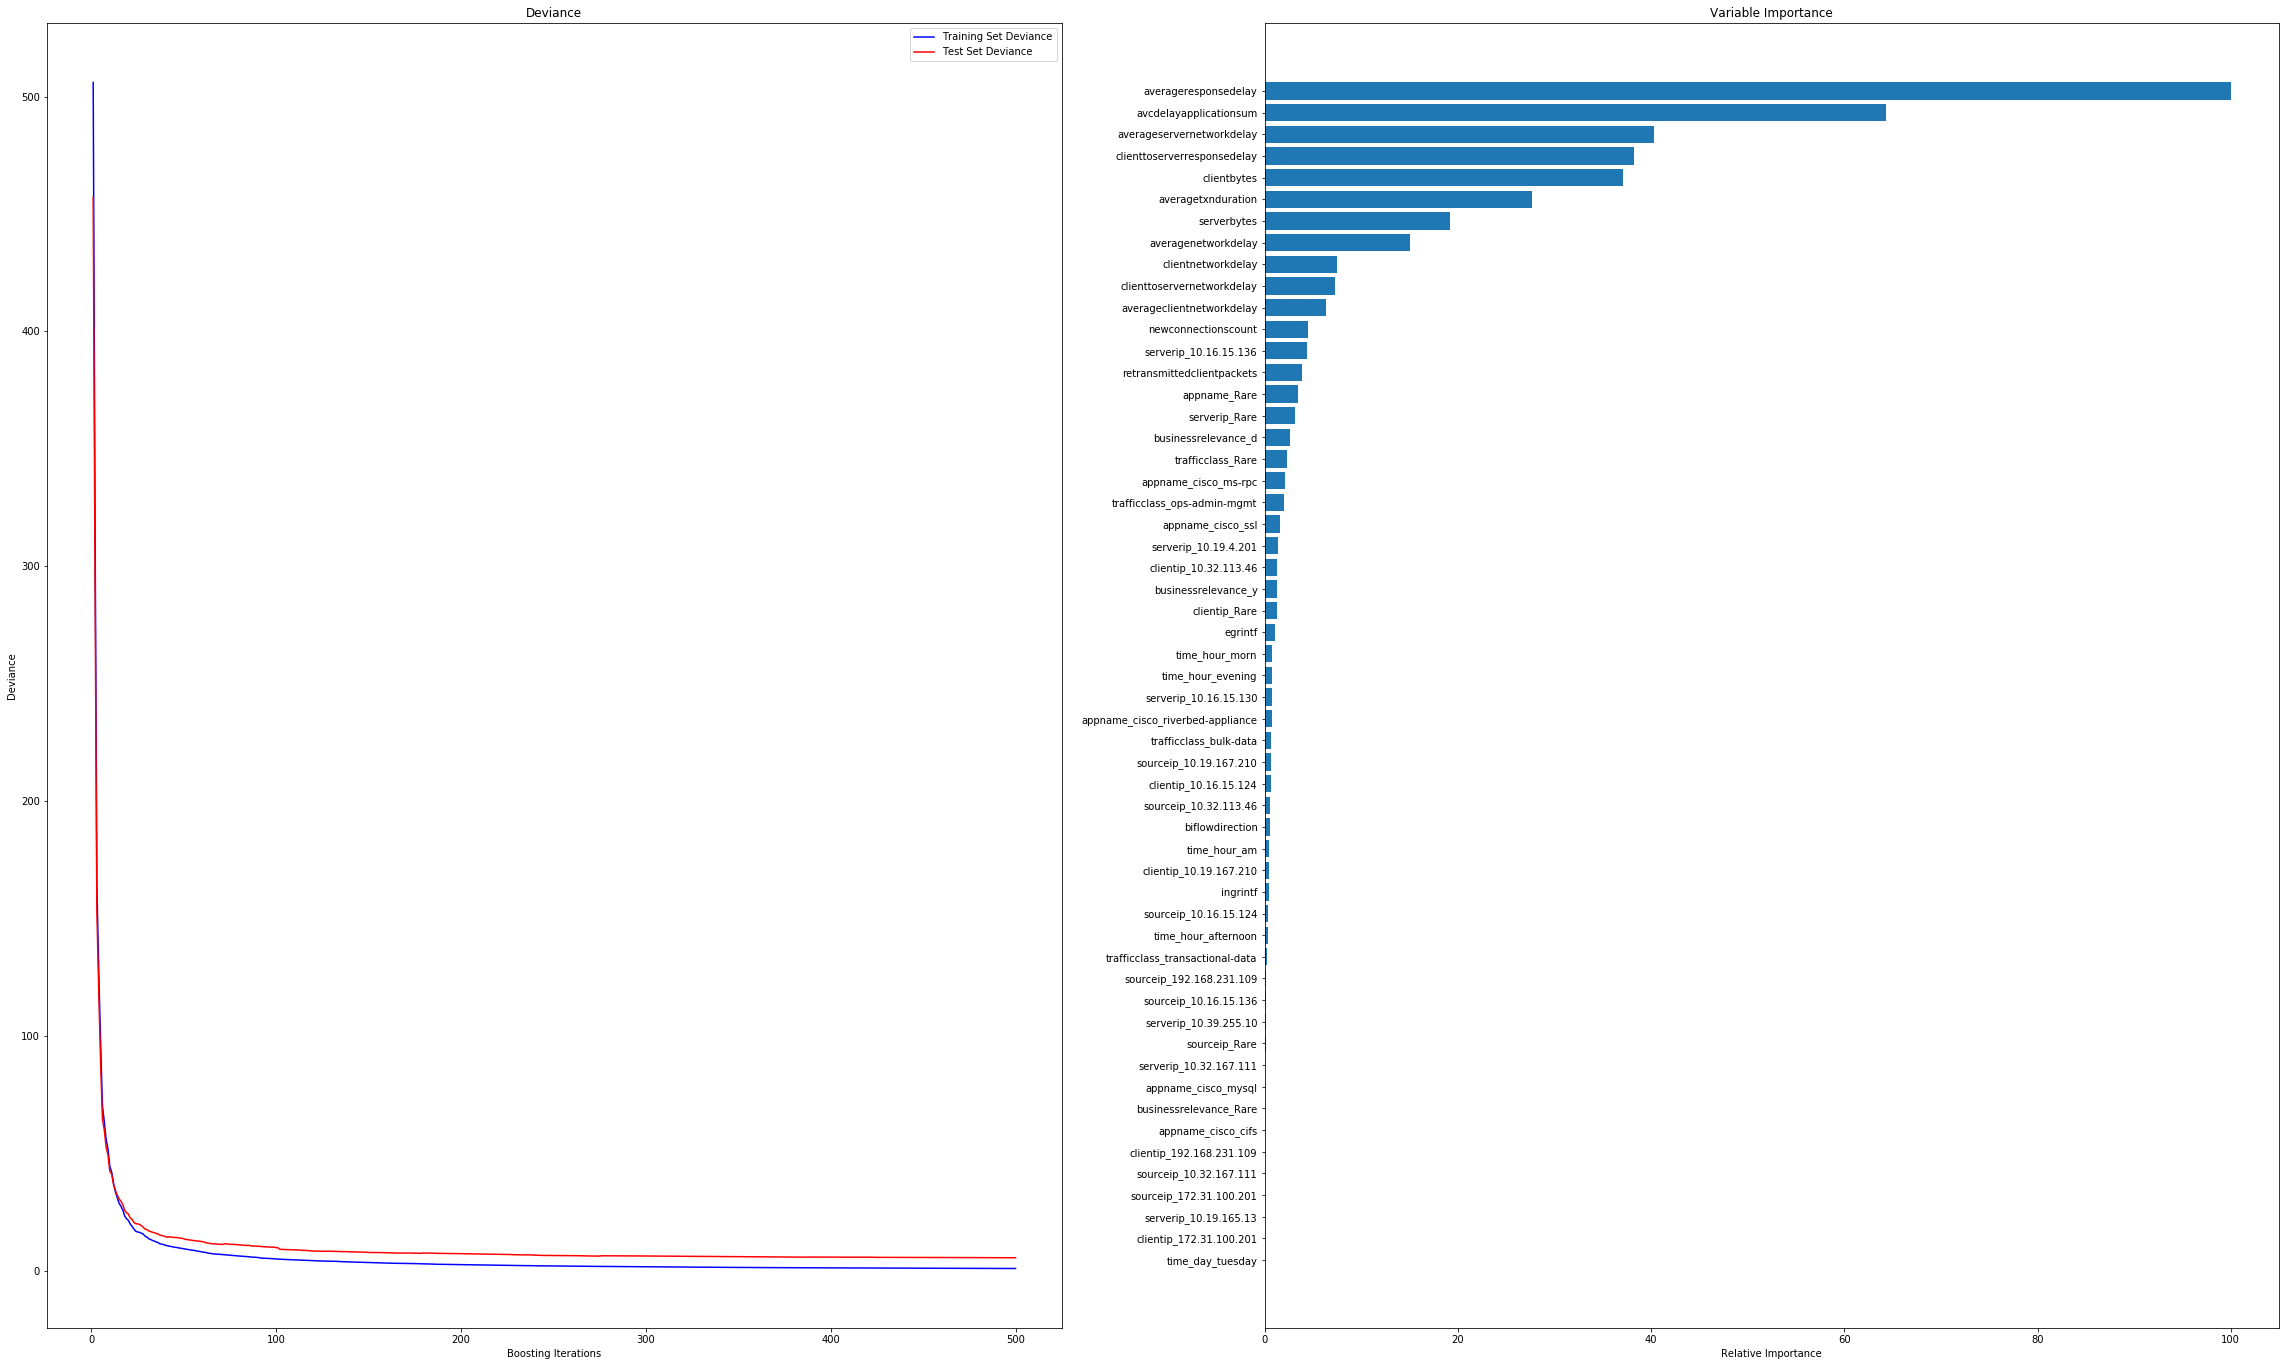

In [117]:
## Low MSE - but I think it's just learning the relationships between AVC Fields

# Shuffle Data

dependent_var = 'averageapplicationdelay'
independent_vars = [i for i in data.columns if i != dependent_var]

ylabels = data[dependent_var].unique()

input_y = data.loc[:, dependent_var]
input_x = data.loc[:, independent_vars]

X, y = shuffle(input_x, input_y, random_state=13)
X = X.astype(np.float32)
offset = int(X.shape[0] * 0.9)
X_train, y_train = X[:offset], y[:offset]
X_test, y_test = X[offset:], y[offset:]

# Fit regression model
params = {'n_estimators': 500, 'learning_rate': 0.5}
clf = ensemble.GradientBoostingRegressor(**params)

clf.fit(X_train, y_train)
mse = mean_squared_error(y_test, clf.predict(X_test))
print("MSE: %.4f" % mse)

# #############################################################################
# Plot training deviance

# compute test set deviance
test_score = np.zeros((params['n_estimators'],), dtype=np.float64)

for i, y_pred in enumerate(clf.staged_predict(X_test)):
    test_score[i] = clf.loss_(y_test, y_pred)

plt.figure(figsize=(40, 24))
plt.subplot(1, 2, 1)
plt.title('Deviance')
plt.plot(np.arange(params['n_estimators']) + 1, clf.train_score_, 'b-',
         label='Training Set Deviance')
plt.plot(np.arange(params['n_estimators']) + 1, test_score, 'r-',
         label='Test Set Deviance')
plt.legend(loc='upper right')
plt.xlabel('Boosting Iterations')
plt.ylabel('Deviance')

# #############################################################################
# Plot feature importance
feature_importance = clf.feature_importances_
# make importances relative to max importance
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5
plt.subplot(1, 2, 2)
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, input_x.columns[sorted_idx])
plt.xlabel('Relative Importance')
plt.title('Variable Importance')
plt.show()

MSE: 718.2849


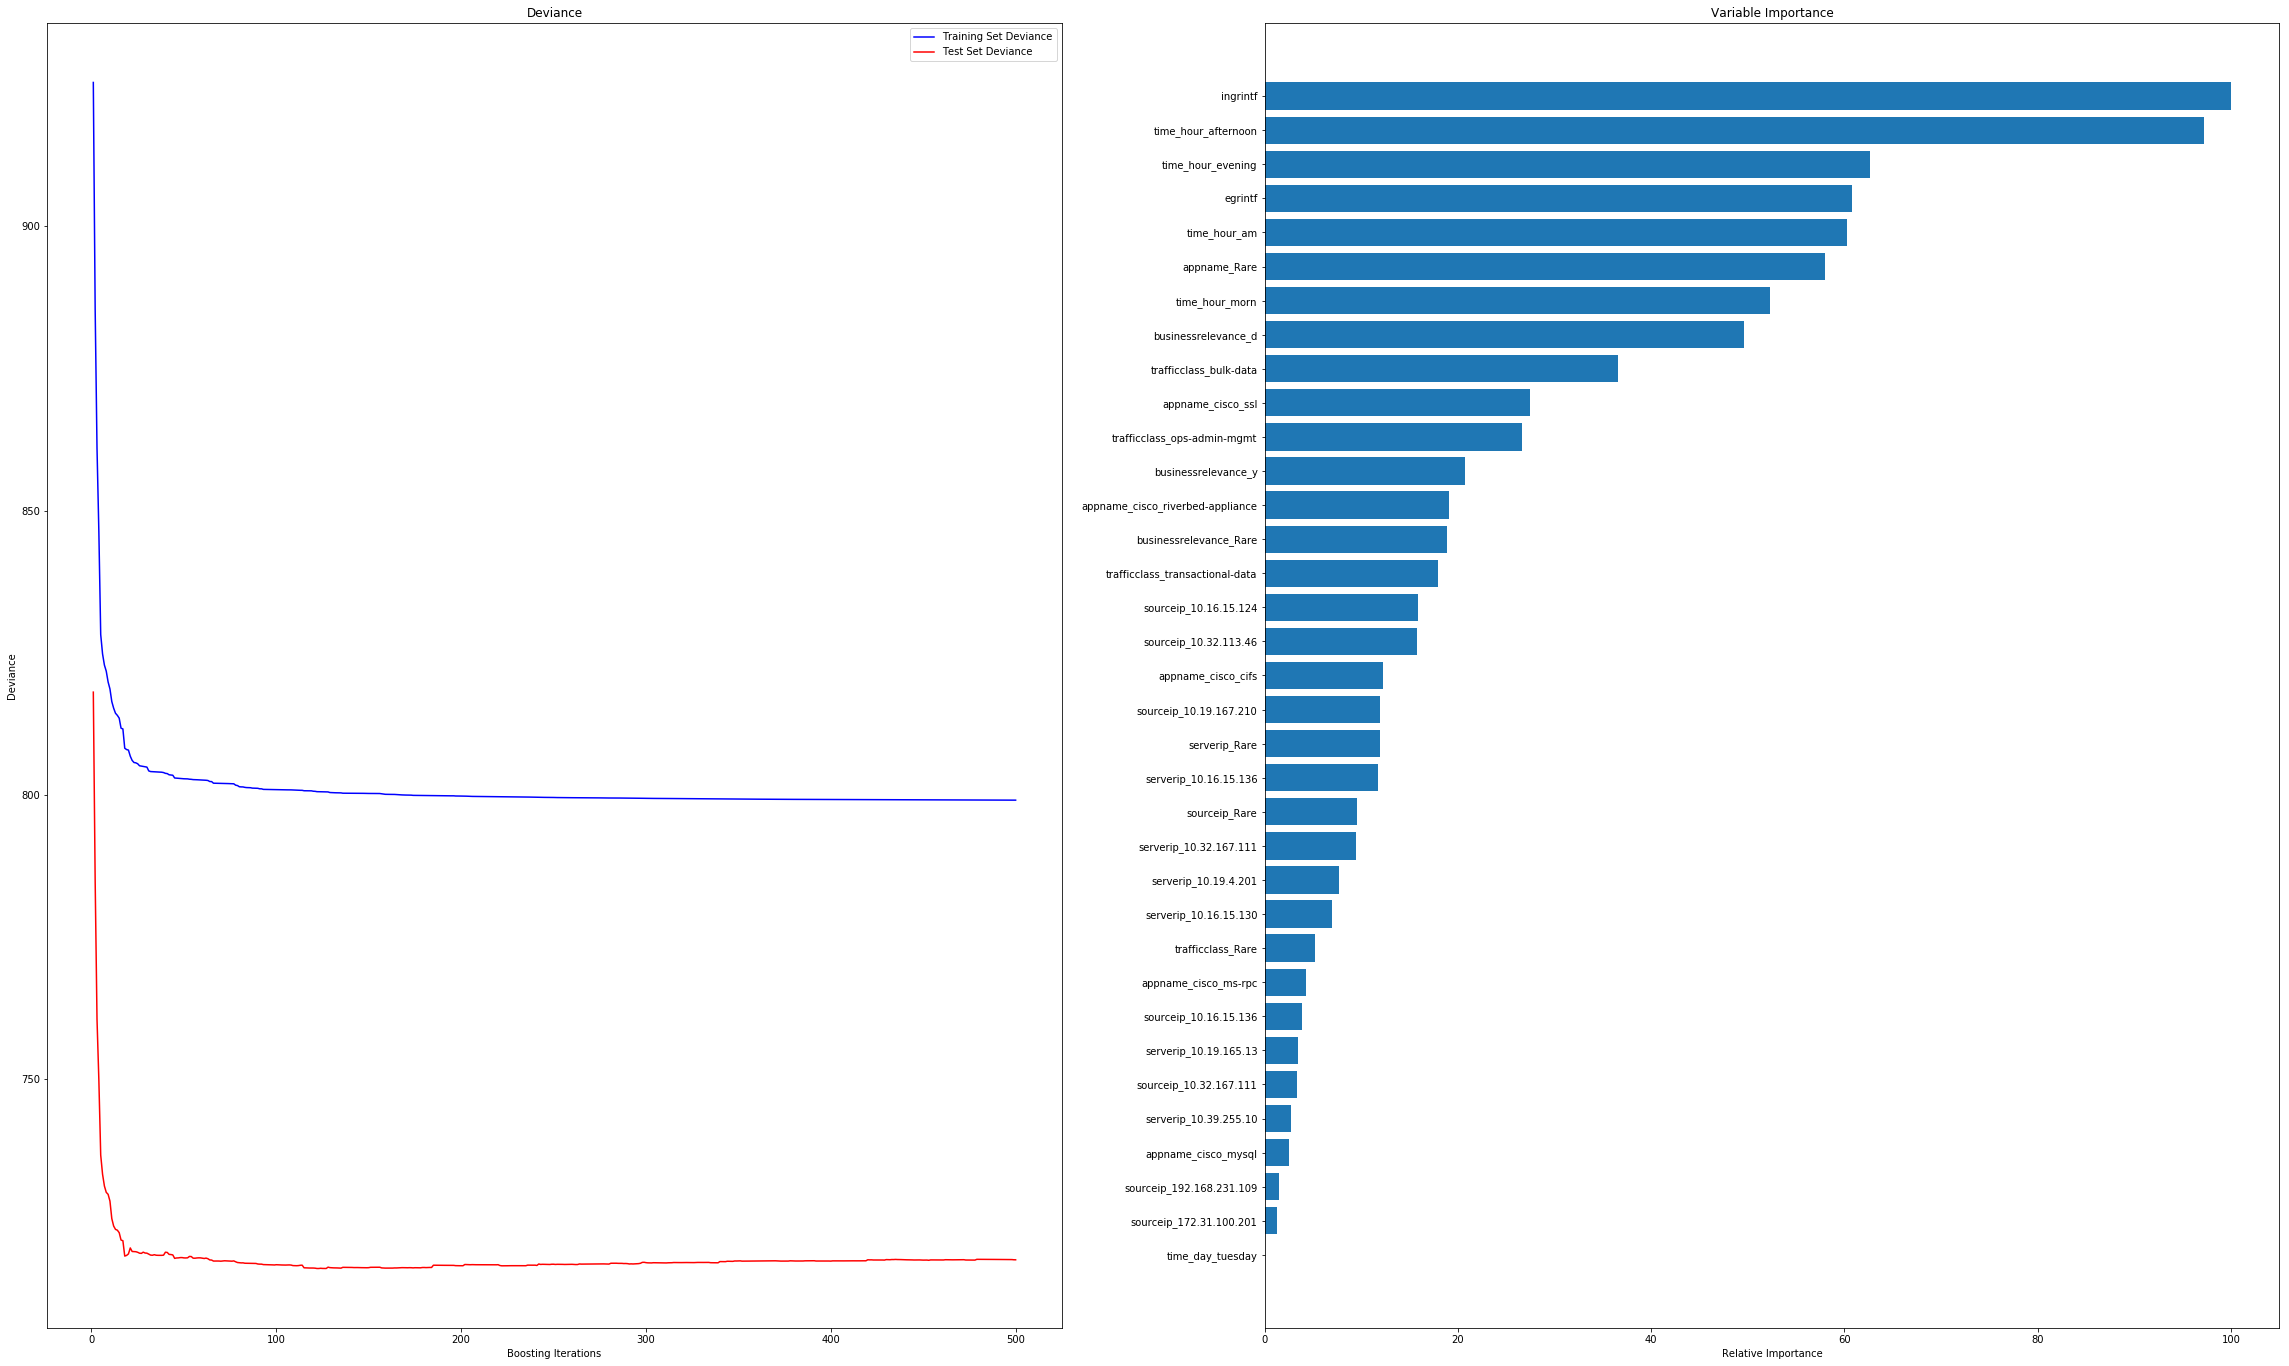

In [120]:
## Very High MSE - and Very Overfit

# Shuffle Data

dependent_var = 'averageapplicationdelay'
independent_vars = [i for i in data.columns if 'serverip' in i
                   or 'sourceip' in i or 'appname' in i or 'relevance' in i 
                    or 'trafficclass' in i or 'time' in i or 'intf' in i]

ylabels = data[dependent_var].unique()

input_y = data.loc[:, dependent_var]
input_x = data.loc[:, independent_vars]

X, y = shuffle(input_x, input_y, random_state=13)
X = X.astype(np.float32)
offset = int(X.shape[0] * 0.9)
X_train, y_train = X[:offset], y[:offset]
X_test, y_test = X[offset:], y[offset:]

# Fit regression model
params = {'n_estimators': 500, 'learning_rate': 0.5}
clf = ensemble.GradientBoostingRegressor(**params)

clf.fit(X_train, y_train)
mse = mean_squared_error(y_test, clf.predict(X_test))
print("MSE: %.4f" % mse)

# #############################################################################
# Plot training deviance

# compute test set deviance
test_score = np.zeros((params['n_estimators'],), dtype=np.float64)

for i, y_pred in enumerate(clf.staged_predict(X_test)):
    test_score[i] = clf.loss_(y_test, y_pred)

plt.figure(figsize=(40, 24))
plt.subplot(1, 2, 1)
plt.title('Deviance')
plt.plot(np.arange(params['n_estimators']) + 1, clf.train_score_, 'b-',
         label='Training Set Deviance')
plt.plot(np.arange(params['n_estimators']) + 1, test_score, 'r-',
         label='Test Set Deviance')
plt.legend(loc='upper right')
plt.xlabel('Boosting Iterations')
plt.ylabel('Deviance')

# #############################################################################
# Plot feature importance
feature_importance = clf.feature_importances_
# make importances relative to max importance
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5
plt.subplot(1, 2, 2)
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, input_x.columns[sorted_idx])
plt.xlabel('Relative Importance')
plt.title('Variable Importance')
plt.show()

In [ ]:
###########################################
###########################################
###########################################
###########################################
### GroupBy
###########################################
###########################################
###########################################
###########################################
###########################################
###########################################

In [183]:
## Make Pivot Table Out of Interest Columns

groupby_cols = ['serverip' ,'appname', 'time_hour']
map_cols = dict()
map_cols['averageservernetworkdelay'] = 'mean'
map_cols['averageclientnetworkdelay'] = 'mean'
map_cols['averageapplicationdelay'] = 'mean'
map_cols['serverbytes'] = 'sum'
map_cols['clientbytes'] = 'sum'

def map_items(data_groupby, map_cols, groupby_cols):
    dict_cols = [i for i in map_cols.keys()]
    data_gp = data_groupby.pivot_table(dict_cols, index=groupby_cols, aggfunc=map_cols)
    return data_gp
data_parsed = map_items(data_groupby, map_cols, groupby_cols)

In [184]:
## Calculate Percentages Of Data ## 

data_parsed['total_bytes'] = data_parsed['clientbytes'] + data_parsed['serverbytes']
total_bytes = data_parsed['total_bytes'].sum()
data_parsed['total_bytes_percent'] = data_parsed.loc[:,'total_bytes':].sum(axis=1)/total_bytes * 100

In [185]:
data_interest = data_parsed[data_parsed['total_bytes_percent'] > 1]

print('Average AD For All Traffic Is {0}\n\n'.format(round(data_parsed['averageapplicationdelay'].mean(),1)))

for i, v in data_interest.sort_values(by=['averageapplicationdelay'], ascending=False).iterrows():
    total_bytes_percent = v.loc['total_bytes_percent']
    averageapplicationdelay = v.loc['averageapplicationdelay']
    print('{0} : {1} Avg AD {2}% of total bytes'.format(i, round(averageapplicationdelay, 1), round(total_bytes_percent, 1)))

Average AD For All Traffic Is 18.4


('10.16.15.136', 'cisco_ssl', 'afternoon') : 40.0 Avg AD 1.3% of total bytes
('10.16.15.136', 'cisco_ssl', 'am') : 39.1 Avg AD 1.4% of total bytes
('10.16.15.136', 'cisco_ssl', 'evening') : 34.3 Avg AD 1.8% of total bytes
('10.16.15.136', 'cisco_ssl', 'morn') : 32.8 Avg AD 1.6% of total bytes
('Rare', 'cisco_ssl', 'afternoon') : 20.8 Avg AD 1.7% of total bytes
('Rare', 'cisco_ssl', 'evening') : 13.2 Avg AD 2.1% of total bytes
('Rare', 'cisco_ssl', 'morn') : 12.7 Avg AD 2.5% of total bytes
('Rare', 'cisco_ssl', 'am') : 11.8 Avg AD 3.4% of total bytes
('Rare', 'cisco_ms-rpc', 'morn') : 4.9 Avg AD 6.4% of total bytes
('Rare', 'cisco_ms-rpc', 'afternoon') : 4.8 Avg AD 5.4% of total bytes
('Rare', 'cisco_ms-rpc', 'am') : 4.0 Avg AD 9.6% of total bytes
('Rare', 'cisco_ms-rpc', 'evening') : 3.6 Avg AD 6.6% of total bytes
('10.32.167.111', 'cisco_ssl', 'afternoon') : 1.9 Avg AD 2.3% of total bytes
('10.32.167.111', 'cisco_ssl', 'morn') : 1.8 Avg AD 2.3% of 